# **DeePTB** 快速上手指南 | 训练 Silicon 的紧束缚模型模型

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023 @ Authors</i></b><br/>
        作者: <a style="font-weight:normal" href="mailto:guqq@pku.edu.cn">顾强强 📨 </a>, <a href="mailto:zhouyinzhanghao@gmail.com">周寅张皓 📨 </a></b></i><br/>
        日期：2023-07<br/>
        共享协议：本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        快速开始：点击上方的 <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> 按钮，选择 <span style='color:rgb(85,91,228); font-weight:bold'>DeePTB:v0.1.0</span> 镜像及 <span style='color:rgb(85,91,228); font-weight:bold'>c8_m16_cpu</span> 节点配置，稍等片刻即可运行。
    </p>
</div>



<p style="color:purple; font-weight:bold">DeePTB是使用深度学习构建第一性原理精度的紧束缚（TB）模型的方法，可用于加速材料的电子结构计算。本教程主要介绍DeePTB的基本操作，涉及数据的准备、模型训练以及调用。</p>

完成本案例可以获得：
1. 熟悉 DeePTB 模型的训练流程
2. 得到高精度的硅晶体的完整 DeePTB 模型
3. 熟悉 DeePTB 性质计算模块的使用方式

## 目录

* [方法介绍](#method)
* [方法实践](#practice)
  * [1. 数据准备](#dataprepare)
  * [2. 训练模型](#train)
  * [3. 性质计算](#application)

## 方法介绍: <a id ='method'></a>
DeePTB 方法的基本思想是通过深度学习DFT电子能带，从而构建紧束缚（TB）模型，从而实现第一性原理精度的电子结构和性质计算。 
在紧束缚模型中，哈密顿矩阵元可以表示为:
$
\begin{equation}
H_{i,j}^{lm,l^\prime m^\prime} =  \left\langle {i,lm} \right| \hat{H} \left| {j, l^\prime m^\prime} \right\rangle 
\end{equation}
$
其中$i$, $j$ 是site指标。$l$ 和 $m$ 是 angular and magnetic quantum number。 DeePTB的方法的目标就是通过学习DFT的电子能量本征值，利用神经网络预测给定结构的哈密顿量矩阵元。但是，由于哈密顿量本身具有规范变化自由度，因此电子能量本征值并不能完全决定哈密顿量。因此我们这里选取了传统的 Slater-Koster (SK) 参数化的哈密顿量，即:所有的哈密顿量跃迁矩阵元可以从规范无关的参数SK键积分: $h_{ss\sigma}, h_{sp\sigma}, h_{pp\sigma}, h_{pp\pi}, \cdots$等来表示。根据这些键积分，我们可以构建变换到哈密顿量矩阵元，即:
$
\begin{equation}
	H_{i,j}^{lm,l^\prime m^\prime} = \sum_{\zeta} \Big[ \mathcal{U}_{\zeta}(\hat{r}_{ij}) \ h_{ll^\prime \zeta} \Big]_{mm^\prime}
\end{equation}
$
这里$\mathcal{U}_{\zeta}$ 是一个$[2l+1,2l^\prime+1]$的矩阵，$\zeta$表示成键类型如：$\sigma, \pi$等。$\mathcal{U}_{\zeta}$的具体形式可以参考[Ref:1](https://journals.aps.org/pr/abstract/10.1103/PhysRev.94.1498)

传统的SK-TB中，SK键积分往往采用了一下经验规则下的解析表达式，且基于双中心近似并只和两个原子的距离有关。 在DeePTB中，我们采用了一种基于神经网络的方法来预测SK键积分，即:
$
\begin{equation}
h^{\text{env}}_{ll^\prime{\zeta}} =  h_{ll^\prime{\zeta}}(r_{ij}) \times \left[1+\Phi_{ll^\prime\zeta}^{o_i,o_j}\left(r_{ij},\mathcal{D}^{ij}\right)\right]	
\end{equation}
$

其中$h_{ll^\prime{\zeta}}$ 同样是基于解析表达式且只两个原子的距离有关的SK键积分,在DeePTB 中解析表达式的待定系数由trainable神经元表示。而 $h^{\text{env}}_{ll^\prime{\zeta}}$ 则是利用神经网络引入键局域环境修正后，局域环境依赖的键积分。 除了跃迁项外，紧束缚哈密顿量其他元素，如占位能，以及自选轨道耦合 SOC作用强度等参数也进行类似的参数化形式。在DeePTB的文章中，我们有对方法进行详细的解释和说明，搭配使用将会对读者有更好的理解。请参考 [DeePTB paper](https://arxiv.org/abs/2307.04638)。

DeePTB 方法的主要思路可以总结为如下图所示：

<img src="https://raw.githubusercontent.com/QG-phy/deeptb/dev/doc/img/model_arch.png" alt="Fig1" style="zoom: 40%;">



基本流程为：
1. 数据准备：
   - 结构数据
   - DFT电子能带数据
2. 模型训练：
   - 训练神经网络参数化的经验紧束缚 (nnsk) 模型.
   - 训练包含环境修正的深度学习紧束缚（dptb）模型.
3. 模型测试：
   - 模型性能测试
   - 模型性质计算


**NOTE**： DeePTB方法的训练label是DFT的电子能量本征值，因此DeePTB方法没有要求本征值的来源，不仅仅是可以LCAO基组的DFT软件，也可以是基于平面波基组的DFT软件，也并不会要求必须是某一种泛函，甚至如果可以的话，可以是来自实验的能带数据。

## 方法实践 <a id ='practice'></a>


在常温常压下，Silicon 具有金刚石结构，其在半导体行业具有广泛应用，且具有重要意义。在这里，我们提供一个构建单晶硅的 **DeePTB** 模型的例子。按照这个步骤，您将了解到 **DeePTB** 的大部分功能，训练完成后，可以得到一个拥有第一性原理精度的深度学习TB模型。

我们提供了一些每一步收敛的模型，以供随时查验结果，模型目录在：
```bash
deeptb/examples/silicon/ckpt/
-- md/
-- -- 2-3-25K_best_nnsk_b5.000_c5.000_w0.100.pth # nnsk model trained on 25K MD trajectory
-- -- 2-3-100K_best_nnsk_b5.000_c5.000_w0.100.pth # nnsk model trained on 100K MD trajectory
-- -- 2-3-300K_best_dptb_b5.000_c5.000_w0.100.pth # nnsk model trained on 300K MD trajectory
-- -- 2-3-300K_best_nnsk_b5.000_c5.000_w0.100.pth # dptb model trained on 300K MD trajectory
-- 2-1_best_nnsk_b2.600_c2.600_w0.300.pth
-- 2-2-1_best_nnsk_b2.600_c2.600_w0.300.pth
-- 2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth
```

首先我们定位到silicon样例的目录

In [4]:
import os
os.chdir("//root/software/git/DeePTB/examples/silicon/")

### **1. 数据准备** <a id ='dataprepare'></a>


用以训练模型，和画图验证的数据放在 `data` 文件夹里：
```bash
deeptb/examples/silicon/data/
|-- kpath.0                 # train data of primary cell. (k-path bands)
|-- kpathmd25.0             # train data of 10 MD snapshots at T=25K   (k-path bands)
|-- kpathmd100.0            # train data of 10 MD snapshots at T=100K  (k-path bands)
|-- kpathmd300.0            # train data of 10 MD snapshots at T=300K  (k-path bands)
|-- kpt.0                   # kmesh samples of primary cell  (k-mesh bands)
`-- silicon.vasp            # structure of primary cell
```

该文件夹下数据集的含义如下：
- `kpath.0`：单胞的能带数据
- `kpathmd25.0`：25K下的10个MD快照的能带数据
- `kpathmd100.0`：100K下的10个MD快照的能带数据
- `kpathmd300.0`：300K下的10个MD快照的能带数据
- `kpt.0`：单胞的k点网格采样数据
- `silicon.vasp`: 单胞的结构数据

每个数据集都包含了**DeePTB**的数据文件，例如`kpath.0`：
```bash
deeptb/examples/silicon/data/kpath.0/
-- bandinfo.json
-- eigs.npy
-- kpoints.npy
-- xdat.traj
```
其中：
- `bandinfo.json`：能带数据的信息，包含了能带的窗口，可以按照能带指标排序，也可以按照能量大小划分如：
    ```json
    {
    "band_min": 0,
    "band_max": 8,
    "emin": null,
    "emax": null
    }
    ```
- `eigs.npy`：能带数据，shape为`[n_snapshots, nkpointsm, nbands]`
- `kpoints.npy`：k点数据，shape为`[nkpoints, 3]`
- `xdat.traj`: 轨迹结构数据，可以用ase进行读取

### **2. 训练模型** <a id ='train'></a>

NNSK:指的是利用神经网络参数化SK积分的表达式的待定系数。
这里默认我们采用 power-low的函数形式：
$
\begin{equation}
h_{ll^\prime\zeta}(r_{ij}) =  h^0 \left(\frac{r_{\text{ref}}}{r_{ij}}{}\right)^\alpha
\end{equation}
$
为了引起额外的衰减函数的调控，我们引入一个指数衰减的截断函数：

$
\begin{equation}
f_{cut}(r_{ij}) = \left(1+\exp\left(\frac{r_{ij}-r_{{skc}}}{w}\right)\right)^{-1}
\end{equation}
$

因此，我们的神经网络的输出为：
$
\begin{equation}
h_{ll^\prime\zeta}(r_{ij}) =  h^0 \left(\frac{r_{\text{ref}}}{r_{ij}}{}\right)^\alpha \times \left(1+\exp\left(\frac{r_{ij}-r_{skc}}{w}\right)\right)^{-1}
\end{equation}
$

其中，$h^0$，$\alpha$，为训练参数。$r_{\text{ref}}$ 采用一个atom-wise的参考数值。  $r_{\text{cut}}$，$w$都是可训练的参数。是一个训练过程中的额外的控制参数。


####  **2.1 训练 nnsk 模型的一近邻**
首先我们分析一下拟合硅的键长结构，运行命令

In [5]:
!dptb bond ./data/silicon.vasp

 Bond Type         1         2         3         4         5
------------------------------------------------------------------------
     Si-Si      2.35      3.84      4.50      5.43      5.92



可以查看到训练的硅结构的键长分布，可以看到一近邻的键长在2.35，因此我们第一步设置参数时，将键长的cutoff截断到2.35到3.84之间. 这里我们取2.6，详细参数配置参考`./ckpt/2-1_input.json`. 其中一些关键参数如：
```json
    "common_options": {
        "onsitemode": "none",
        "bond_cutoff": 2.6,
        "atomtype": ["Si"],
        "proj_atom_anglr_m": {"Si": ["3s","3p"]}
    }
    "model_options": {
        "sknetwork": {
            "sk_hop_nhidden": 1,
            "sk_onsite_nhidden": 1},
        "skfunction": {
            "sk_cutoff": 2.6,
            "sk_decay_w": 0.3
        }
```
- `onsitemode`：表示是否使用占位能，这里我们不训练占位能，直接采用中性原子的轨道能力，因此设置为`none`。
- `bond_cutoff`：表示键长的截断半径，这里我们设置为2.6。表示只考虑第一紧邻
- `atomtype`：表示训练的原子类型，这里我们只训练硅原子，因此设置为`Si`
- `proj_atom_anglr_m`：表示投影的轨道，这里我们只投影3s和3p轨道，因此设置为`{"Si": ["3s","3p"]}`
- `sk_hop_nhidden`：表示SK键积分的隐藏层的层数，这里我们设置为1层
- `sk_onsite_nhidden`：表示SK占位能的隐藏层的层数，这里我们设置为1层，当onsitemode= none，不起作用。
- `sk_cutoff`: 表示SK键积分的截断函数的$r_{cut}$，这里我们设置为2.6，即上述截断公式中的
- `sk_decay_w`: 表示SK键积分的截断函数的衰减系数$w$，这里我们设置为0.3。


下面我们运行命令进行模型训练:

In [6]:
# run time ~ 23 sec.
!dptb train -sk ./ckpt/2-1_input.json -o ./nnsk

./data/kpath_spk.*
./data/kpath_spk.*
./data/kpath_spk.*
# initial rotate H or S func.
DEEPTB INFO    iteration:1	train_loss: 50.7691  (15.2307)	validation_loss: 49.8418  (14.9526)	lr: 0.01
DEEPTB INFO    Epoch 1 summary:	train_loss: 50.7691	validation_loss: 49.8418	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as best_nnsk_b2.600_c2.600_w0.300
DEEPTB INFO    iteration:2	train_loss: 41.3913  (23.0789)	validation_loss: 39.1407  (22.2090)	lr: 0.00999
DEEPTB INFO    Epoch 2 summary:	train_loss: 41.3913	validation_loss: 39.1407	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as best_nnsk_b2.600_c2.600_w0.300
DEEPTB INFO    iteration:3	train_loss: 33.0812  (26.0796)	validation_loss: 29.8788  (24.5099)	

训练完成后，我们可以画图看看能带拟合怎么样了，需要准备这样的能带绘制参数：
```json

{   
    "structure":"./data/silicon.vasp",
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,  50],   
                [0.5000000000,   0.0000000000,   0.5000000000,  50],               
                [0.6250000000,   0.2500000000,   0.6250000000,  1],    
                [0.3750000000,   0.3750000000,   0.7500000000,  50],     
                [0.0000000000,   0.0000000000,   0.0000000000,  50],    
                [0.5000000000,   0.5000000000,   0.5000000000,  50],                
                [0.5000000000,   0.2500000000,   0.7500000000,  50],               
                [0.5000000000,   0.0000000000,   0.5000000000,  1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "E_fermi":-7.5,
        "emin":-12,
        "emax":12,
        "ref_band": "./data/kpath.0/eigs.npy"
    }
}
```

各参数表示：
- `task`: 运行的任务, 这儿我们要画能带所以写 "band".
- `kline_type`: 生成K点路径的方法, 在这用 abacus 的K点路径算法.
- `kpath`: 形状为 (:,4)的list或者array, 这里 前三列，[:,:3] 是K点路径, 这里用高对称点上的K点值来定义K点路径, 第四列，[:,3] 表示了相邻两个高对称点之间的K点数.
- `klabels`: 高对称点的标签.
- `E_fermi`: 系统的费米能.
- `emin`: 绘制的能带能量最低点，是对于费米能的相对值.
- `emax`: 绘制的能带能量最高点.
- `ref_band`: 对比的能带数据，要求数据产生时的K点设置和这里的设置相同.

Warning! structure is not set in run option, read from input config file.
./data/silicon.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi from jdata: -9.307, While the estimated value in line-mode is -5.036673545837402
Figure(450x400)
DEEPTB INFO    band calculation successfully completed.


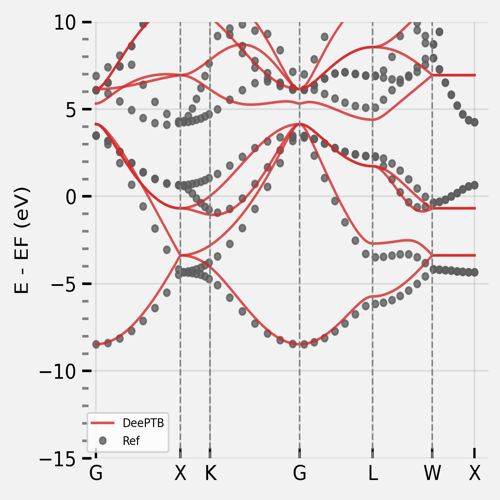

In [7]:
!dptb run -sk run/band.json -i ./nnsk/checkpoint/best_nnsk_b2.600_c2.600_w0.300.pth -o ./band
#!dptb run -sk run/band.json -i ./ckpt/2-1_best_nnsk_b2.600_c2.600_w0.300.pth -o ./band
from IPython.display import display
from PIL import Image
# display(Image.open("./band/results/band.png",resize=True))
image = Image.open("./band/results/band.png")
image = image.resize((500, 500))
display(image)

**小结**: 可以看出该模型已经具有能带的大致形状。要注意的是这里我们只是采用了$s,p$轨道，只考虑**第一近邻**。如果我们后续只需要价带的信息，那么**无需增加轨道**，只需要修改训练的能带窗口和调整权重，并可以通过增加近邻的方式得到一个更准确的价带的TB模型。
可是往往，我们需要导带的信息，这时候我们需要引入更多的轨道，**DeePTB** 支持用户自由地在训练过程中增减轨道和近邻。我们下一步进行增加轨道和近邻的训练


####  **2.2 增加轨道和近邻**

#####  **2.2.1 增加轨道**

通过修改输入文件，我们在这里加入辅助轨道 `d*`，使模型能够拟合考虑的导带。这对于一些需要导带的性质地计算，例如光电性质，和电子的输运性质至关重要。另外在第一步的时候，我们onsite 没有加修正。我们这里也开启 strian mode，让模型能够更新 onsie 矩阵。

```json
"onsitemode": "strain",
"onsite_cutoff": 2.5,
"proj_atom_anglr_m": {
     "Si": [
          "3s",
          "3p",
          "d*"
     ]
}
```

这里"onsitemode": "strain" 表示开启 strian mode 的onsite matrix 修正。相应的需要提供一个 "onsite_cutoff"的参数，用来表明在strian 模型下，onsite matrix 只考虑onsite_cutoff以内的原子的贡献。通常选取第一近邻。


同时，我们得修改学习率到 `1e-3`，让初始化更加稳定接着，我们通过 `-i[init-model]` 加载上一步训练的模型，运行：

In [8]:
#!dptb train -sk ./ckpt/2-2-1_input.json -i ./ckpt/2-1_best_nnsk_b2.600_c2.600_w0.300.pth -o nnsk
# run time: ~ 130 sec.
!dptb train -sk ./ckpt/2-2-1_input.json -i ./nnsk/checkpoint/best_nnsk_b2.600_c2.600_w0.300.pth -o nnsk

./data/kpath_spk.*
./data/kpath_spk.*
./data/kpath_spk.*
# initial rotate H or S func.
DEEPTB INFO    iteration:1	train_loss: 4.6707  (1.4012)	validation_loss: 2.9321  (0.8796)	lr: 0.001
DEEPTB INFO    Epoch 1 summary:	train_loss: 4.6707	validation_loss: 2.9321	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as best_nnsk_b2.600_c2.600_w0.300
DEEPTB INFO    iteration:2	train_loss: 4.4945  (2.3292)	validation_loss: 2.4734  (1.3578)	lr: 0.000999
DEEPTB INFO    Epoch 2 summary:	train_loss: 4.4945	validation_loss: 2.4734	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as best_nnsk_b2.600_c2.600_w0.300
DEEPTB INFO    iteration:3	train_loss: 4.0220  (2.8370)	validation_loss: 2.1347  (1.5908)	lr: 0.000998
D

收敛后查看能带拟合结果

Warning! structure is not set in run option, read from input config file.
./data/silicon.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi from jdata: -9.307, While the estimated value in line-mode is -8.228470802307129
Figure(450x400)
DEEPTB INFO    band calculation successfully completed.


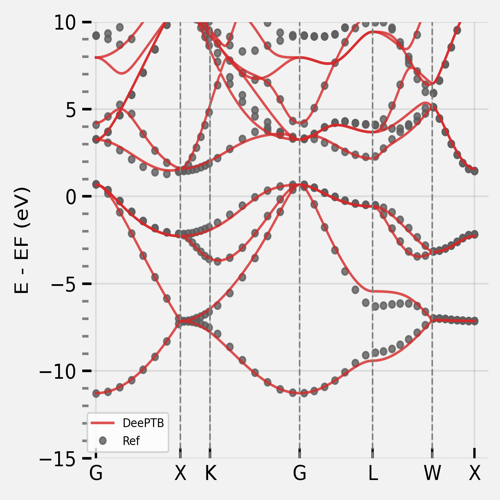

In [10]:
!dptb run -sk run/band.json -i ./nnsk/checkpoint/best_nnsk_b2.600_c2.600_w0.300.pth -o ./band
#!dptb run -sk run/band.json -i ./ckpt/2-2-1_best_nnsk_b2.600_c2.600_w0.300.pth -o ./band
from IPython.display import display
from PIL import Image
# display(Image.open("./band/results/band.png",resize=True))
image = Image.open("./band/results/band.png")
image = image.resize((500, 500))
display(image)

**Note**: 实际使用中，我们发现用最小基组作为初始训练，并逐渐增加基组的策略，比直接用完整的轨道初始化从头训练更好。这同时可以帮助我们减小使用的基组数，并提升训练的稳定性。*

这里可以看到，能带拟合结果已经相当准确。

#####  **2.2.2 增加近邻**

为了进一步提高精度，我可以通过增加键长的阶段，考虑更远的近邻的紧束缚模型。
- `bond_cutoff` (angstrom unit): it indicates bonds that have a bond-length smaller than what is included.

We first increase the `bond_cutoff` to be larger than the bong-length of the third nearest neighbour, while shorter than the fourth. However, abrupt change in the cutoff will introduce discontinuity in the model training, we, therefore, introduce a smoothing function:

增加紧邻包含两步操作：
- 1. 增加 `bond_cutoff` 到比如 5.0 包含第三近邻，但不包含第四近邻。
- 2. 因为直接突然从 1 紧邻加入 2,3 近邻的突变，对哈密顿量的变化太大，导致之前的拟合结果失效，因此我们采用一个平滑的阶段函数来过渡。通过缓慢地把截断函数向更远的截断推进，从而实现增加近邻。

截断函数我们采取的是：
$$f_s(r)=\frac{1}{1+e^{(r-r_{skc})/\omega}}$$

通过调整参数，我们可以得到一个平滑的过渡，这里我们设置为：
  - `sk_cutoff` (angstrom unit): $r_{skc}$ it controls the cutoff of the decay weight of each bond.
  - `sk_decay_w`: $\omega$, it decides the smoothness of the decay.

如图所示：

<img src="https://raw.githubusercontent.com/QG-phy/deeptb/dev/examples/silicon/img/fs.png" alt="Fig2" style="zoom: 40%;">

正如上图所示,这个平滑函数将以r_{skc}为中心衰减。根据平滑性ω,这个函数具有不同的平滑性。在这里,为了在保持拟合稳定性的同时考虑更多邻居项,我们首先将r_{skc}设定为第一最近邻距离,这样的衰减函数可以抑制新包含的第二和第三邻居项,这不会对预测的哈密顿带来突然的变化

我们可以将sk_cutoff 从起始第一近邻慢慢外推到新的bond_cutoff(包含三近邻)。
设置 sk_cutoff = [start, end], 即上述公式中的$r_{skc}$ 从第一近邻缓慢外推至第三近邻。一共采用 num_epoch=2000步，每一个epoch 更新 sk_cutoff
$
\begin{equation}
r_{skc}(i_{epoch}) = start + i_{epoch}\times\frac{end-start}{num\_epoch}
\end{equation}
$
**注意** 如果 num_epoch 太小，那么外推的过程就不能称之为缓变，可能会导致模型训练的不收敛。

具体输入文件参考 `ckpt/2-2-2-1_input.json`


类似地，我们也可以将$w$变得更小，衰减更快。这一步是在外推sk_cutoff之后，限制更远的bond不会进入考虑。
此时修改的输入参数为：
```json       
    "sk_cutoff": 5.0,
    "sk_decay_w": [0.3, 0.1]
``` 
具体输入文件参考 `ckpt/2-2-2-2_input.json`


In [11]:
# 第一步外推sk_cutoff
# ~ 50 mins
!dptb train -sk ./ckpt/2-2-2-1_input.json -i ./nnsk/checkpoint/best_nnsk_b2.600_c2.600_w0.300.pth -o nnsk_cut_sk

./data/kpath_spk.*
./data/kpath_spk.*
./data/kpath_spk.*
# initial rotate H or S func.
DEEPTB INFO    iteration:1	train_loss: 0.2290  (0.0687)	validation_loss: 0.0869  (0.0261)	lr: 0.001
DEEPTB INFO    Epoch 1 summary:	train_loss: 0.2290	validation_loss: 0.0869	
################################################################################################################################################################
DEEPTB INFO    checkpoint saved as best_nnsk_b5.000_c2.600_w0.300
DEEPTB INFO    iteration:2	train_loss: 0.1852  (0.1037)	validation_loss: 0.1151  (0.0528)	lr: 0.000999
DEEPTB INFO    Epoch 2 summary:	train_loss: 0.1852	validation_loss: 0.1151	
################################################################################################################################################################
DEEPTB INFO    iteration:3	train_loss: 0.1922  (0.1302)	validation_loss: 0.1103  (0.0700)	lr: 0.000998
DEEPTB INFO    Epoch 3 summary:	train_loss: 0.1922	validation_loss:

In [13]:
# 第二步减少 在第一步外推之后的checkpoint之后缓慢降低decay.
# ~ 50 mins
#!dptb train -sk ./ckpt/2-2-2-2_input.json -i ./nnsk_cut_sk/checkpoint/best_nnsk_b5.000_c5.00_w0.300.pth -o nnsk_cut_sk

上述的推近邻的过程，时间稍微较长，用户可以直接直接跳过这一步，直接使用我们提供的模型: `ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth`

我们可以看到，在这一步的能带结果:

Warning! structure is not set in run option, read from input config file.
./data/silicon.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi from jdata: -9.307, While the estimated value in line-mode is -9.30657958984375
Figure(450x400)
DEEPTB INFO    band calculation successfully completed.


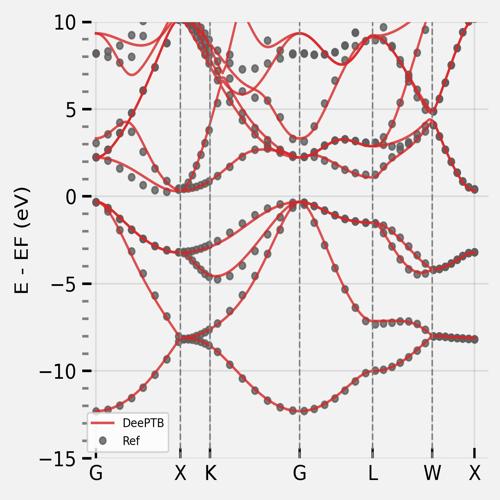

In [14]:
!dptb run -sk run/band.json -i ./ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth -o ./band
#!dptb run -sk run/band.json -i ./ckpt/2-2-1_best_nnsk_b2.600_c2.600_w0.300.pth -o ./band
from IPython.display import display
from PIL import Image
# display(Image.open("./band/results/band.png",resize=True))
image = Image.open("./band/results/band.png")
image = image.resize((500, 500))
display(image)

####  **2.3 训练MD数据 (键长变化的依赖)**
在 DeePTB 中，基于物理经验建模的 SK 积分由各种键长相关函数参数化。这提供了 nnsk 模型良好的转移性，可以模拟原子畸变对电子结构的变化。但是为了进一步的提高这样的迁移能力，我们强烈建议进行键长依赖性参数的训练。这样的训练可以通过 MD 快照数据集轻松获得。在这里，我们提供了 25K，100K 和 300K 下的 10 个 MD 快照的数据集。用户可以通过修改输入配置中的 data_options/train/prefix 为 kpathmd25K/kpathmd100K/kpathmd300K 并使用初始化检查点训练模型，可以轻松获得参数。(这里的能带数据中k点的选取比较密，会降低一定的计算速度。用户可以自行选取部分k点，例如隔3个选取一个点，进行训练。)

我们给用户提供了相应训练之后的模型。在 ckpt/md 存在不同温度下的 MD 快照上收敛的 nnsk 模型检查点。用户可以使用 band_md.json 命令绘制能带结构。

In [15]:
# ~ several hrs. 用户可以根据 validation_loss 的变化来决定何时停止训练。不一定要把训练跑完。

!dptb train -sk ./ckpt/md/input.json -i ./ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth -o ./nnskmd

./data/kpathmd25.*
./data/kpath.*
./data/kpath.*
# initial rotate H or S func.
DEEPTB INFO    iteration:1	train_loss: 0.0868  (0.0260)	validation_loss: 0.1228  (0.0368)	lr: 0.001
DEEPTB INFO    iteration:2	train_loss: 0.1050  (0.0497)	validation_loss: 0.1309  (0.0651)	lr: 0.001
DEEPTB INFO    iteration:3	train_loss: 0.0960  (0.0636)	validation_loss: 0.0523  (0.0612)	lr: 0.001
DEEPTB INFO    iteration:4	train_loss: 0.1272  (0.0827)	validation_loss: 0.0432  (0.0558)	lr: 0.001
DEEPTB INFO    iteration:5	train_loss: 0.0647  (0.0773)	validation_loss: 0.0424  (0.0518)	lr: 0.001
DEEPTB INFO    iteration:6	train_loss: 0.1717  (0.1056)	validation_loss: 0.0726  (0.0580)	lr: 0.001
DEEPTB INFO    iteration:7	train_loss: 0.0833  (0.0989)	validation_loss: 0.1092  (0.0734)	lr: 0.001
DEEPTB INFO    iteration:8	train_loss: 0.1064  (0.1012)	validation_loss: 0.1468  (0.0954)	lr: 0.001
DEEPTB INFO    iteration:9	train_loss: 0.1172  (0.1060)	validation_loss: 0.1828  (0.1216)	lr: 0.001
DEEPTB INFO    iterat

Warning! structure is not set in run option, read from input config file.
./data/kpathmd300.0/struct.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi from jdata: -9.702, While the estimated value in line-mode is -8.965740203857422
Figure(450x400)
DEEPTB INFO    band calculation successfully completed.


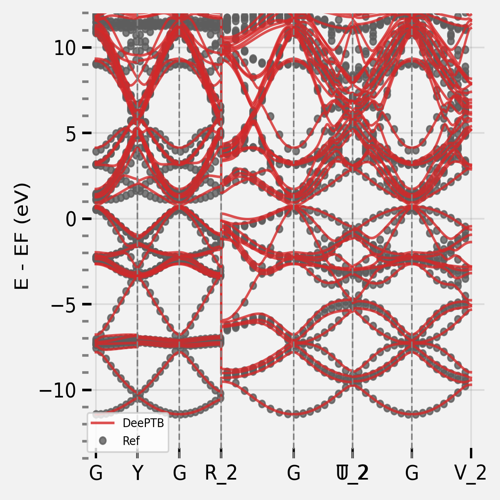

In [16]:
!dptb run band_md.json -sk -i ./ckpt/md/2-3-300K_best_nnsk_b5.000_c5.000_w0.100.pth -o band
from IPython.display import display
from PIL import Image
# display(Image.open("./band/results/band.png",resize=True))
image = Image.open("./band/results/band.png")
image = image.resize((500, 500))
display(image)

####  **2.4 训练环境修正：dptb 模型**

DeePTB提供了具有对称保持神经网络的强大的环境依赖建模。基于上一步，我们可以进一步增强TB模型的能力，以克服由两中心近似带来的精度限制。我们将构建环境依赖性的模型称为dptb。使用上一步中收敛的检查点，我们只需运行

```bash
dptb train <input config> -crt <nnsk checkpoint path> [[-i|-r] <dptb checkpoint path>] [[-o] <output directory>] [-f]
```
环境依赖的dptb模型是需要读取 nnsk的模型。比如我们从上一步的模型 `ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth` 开始训练，我们可以运行：

这里：
- -f 表示固定nnsk部分的参数，只训练环境依赖部分的神经网络参数。这部分的固定是很重要。否则直接的第一步初始化将有可能完全破坏nnsk的参数，导致训练不收敛。
- -crt 后面跟着 nnsk 模型。表明在这个nnsk模型上加 correcttion.
- -i/r 后面跟着 dptb 模型。这是加载 init/restart from 之前已经训练的dptb checkpoint。没有则不加该参数

还有一个特别需要注意的，之前训练 nnsk 模型时，有个参数-sk。现在已经不需要了。

在 input.json 中需要设置一个参数 `env_cutoff` 这个参数是用来提供一个截断半径，用来限制环境依赖的修正。这里我们设置为 4.1。这个参数至少要大于 0.5 * `bond_cutoff`来确保任意一对bond的原子环境都有overlap的原子来标定一下bond原子之间的相对位置信息。




In [17]:
# ~ several hrs. 用户可以根据 validation_loss 的变化来决定何时停止训练。不一定要把训练跑完。

!dptb train ./ckpt/md/input.json -crt ./ckpt/md/2-3-25K_best_nnsk_b5.000_c5.000_w0.100.pth -o dptb -f

./data/kpathmd25.*
./data/kpath.*
./data/kpath.*
# initial rotate H or S func.
DEEPTB INFO    iteration:1	train_loss: 0.2969  (0.0891)	validation_loss: 4.0156  (1.2047)	lr: 0.001
DEEPTB INFO    iteration:2	train_loss: 3.3167  (1.0573)	validation_loss: 0.0477  (0.8576)	lr: 0.001
DEEPTB INFO    iteration:3	train_loss: 0.1073  (0.7723)	validation_loss: 2.1233  (1.2373)	lr: 0.001
DEEPTB INFO    iteration:4	train_loss: 1.4186  (0.9662)	validation_loss: 2.2681  (1.5466)	lr: 0.001
DEEPTB INFO    iteration:5	train_loss: 1.5793  (1.1502)	validation_loss: 0.6728  (1.2844)	lr: 0.001
DEEPTB INFO    iteration:6	train_loss: 0.4207  (0.9313)	validation_loss: 0.0534  (0.9151)	lr: 0.001
DEEPTB INFO    iteration:7	train_loss: 0.0928  (0.6798)	validation_loss: 0.7093  (0.8534)	lr: 0.001
DEEPTB INFO    iteration:8	train_loss: 0.6676  (0.6761)	validation_loss: 0.6024  (0.7781)	lr: 0.001
DEEPTB INFO    iteration:9	train_loss: 0.5910  (0.6506)	validation_loss: 0.2030  (0.6055)	lr: 0.001
DEEPTB INFO    iterat

在训练过程中，dptb模型将定期保存为检查点。如果没有使用-f冻结nnsk模型，则训练后的nnsk模型也将被保存。然后，我们可以使用收敛的模型来预测能带结构以及计算电子性质，或直接获得预测的哈密顿量，作为其他计算TB性质的后处理软件的输入。

下面我们绘制了收敛模型在T=300K的MD轨迹上的能带结构：

Warning! structure is not set in run option, read from input config file.
./data/kpathmd300.0/struct.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi from jdata: -9.702, While the estimated value in line-mode is -9.701650619506836
Figure(450x400)
DEEPTB INFO    band calculation successfully completed.


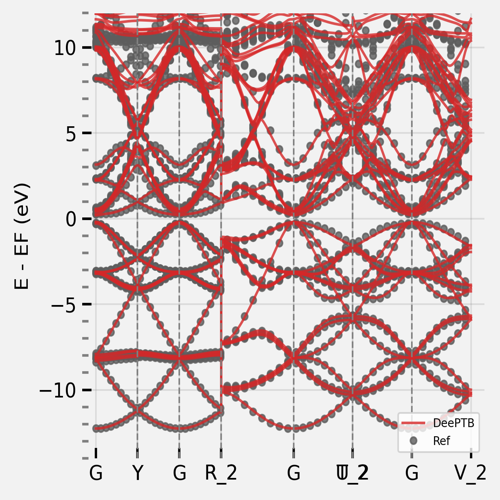

In [18]:
!dptb run band_md.json -i ./ckpt/md/2-3-300K_best_dptb_b5.000_c5.000_w0.100.pth -crt ./ckpt/md/2-3-300K_best_nnsk_b5.000_c5.000_w0.100.pth -o band
from IPython.display import display
from PIL import Image
# display(Image.open("./band/results/band.png",resize=True))
image = Image.open("./band/results/band.png")
image = image.resize((500, 500))
display(image)

In [19]:
!dptb test ./ckpt/md/input_test.json -i ./ckpt/md/2-3-300K_best_dptb_b5.000_c5.000_w0.100.pth -crt ./ckpt/md/2-3-300K_best_nnsk_b5.000_c5.000_w0.100.pth -o test

./data/kpathmd300_test.*
# initial rotate H or S func.
DEEPTB INFO    iteration:1	test_loss: 0.0055  (0.0017)
DEEPTB INFO    iteration:2	test_loss: 0.0055  (0.0028)
DEEPTB INFO    iteration:3	test_loss: 0.0058  (0.0037)
DEEPTB INFO    iteration:4	test_loss: 0.0062  (0.0045)
DEEPTB INFO    iteration:5	test_loss: 0.0059  (0.0049)
DEEPTB INFO    iteration:6	test_loss: 0.0060  (0.0052)
DEEPTB INFO    iteration:7	test_loss: 0.0060  (0.0055)
DEEPTB INFO    iteration:8	test_loss: 0.0056  (0.0055)
DEEPTB INFO    iteration:9	test_loss: 0.0057  (0.0056)
DEEPTB INFO    iteration:10	test_loss: 0.0063  (0.0058)
DEEPTB INFO    finished testing
DEEPTB INFO    wall time: 58.182 s


我们可以将结果拿出，进行预测的可视化对比

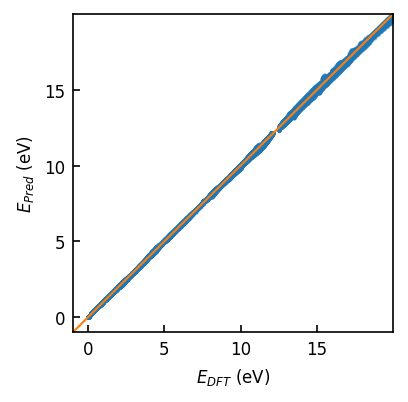

In [20]:
import torch   
import matplotlib.pyplot as plt
import numpy as np

lbel  = torch.load('./test/results/eigenvalues_lbel_ips0')
pred  = torch.load('./test/results/eigenvalues_pred_ips0')

def post_test_eigs(eiglbl,eigpred,bandmin,bandmax,emax):
    eiglbl = eiglbl[:,:,bandmin:bandmax]
    eigpred = eigpred[:,:,bandmin:bandmax]
    nsnaps = eigpred.shape[0]
    eigpred -= eigpred.reshape(nsnaps,-1).min(dim=1)[0].reshape(nsnaps,1,1)
    eiglbl -= eiglbl.reshape(nsnaps,-1).min(dim=1)[0].reshape(nsnaps,1,1)
    eiglbl = eiglbl.numpy()
    eigpred = eigpred.numpy()
    index = eiglbl < emax
    eiglbl_1d = eiglbl[index]
    eigpred_1d = eigpred[index]
    return eiglbl_1d,eigpred_1d

bandmin=0
bandmax=28
emax = 20.0
eiglbl_1d,  eigpred_1d = post_test_eigs(lbel,pred,bandmin,bandmax,emax)

plt.figure(figsize=(7/2.54,7/2.54),dpi=150)
x=np.linspace(-10,40)
plt.plot(eiglbl_1d,eigpred_1d,'o',ms=1.0,alpha=0.3)
plt.plot(x,x,lw=1.0)
plt.xlim(-1,emax)
plt.ylim(-1,emax)
plt.xticks([0,5,10,15],fontsize=8)
plt.yticks([0,5,10,15],fontsize=8)
plt.xlabel('$E_{DFT}$ (eV)',fontsize=8)
plt.ylabel('$E_{Pred}$ (eV)',fontsize=8)
plt.tick_params(direction='in')


### **3. 性质计算** <a id ='application'></a>

得到**DeePTB** 模型之后，我们可以基于TB哈密顿量进行一些性质计算，例如上面案例中展示的能带的计算。也可以进行比如态密度，费米面等计算。同时我们也欢迎用户自己开发一些性质计算的模块，将其集成到 **DeePTB** 中。

**DeePTB** 目前的性质计算的逻辑是集成在 `dptb run` 命令中.  `run` 命令的参数文件包括待计算的结构文件，定义在 `structure` 参数中。以及控制计算所需的参数, 位于 `task_options` 中。其中，根据 `task_options` 中的参数 `task`, 指定不同的计算任务。前面我们已经展示了能带的计算，下面我们展示计算态密度和费米面。

#### **3.1 Density of States (DOS)**.

计算 DOS，我们需要准备一个 DOS 的 设置文件.
```json
{
    "structure":"./data/silicon.vasp",
    "task_options": {
        "task": "dos",
        "mesh_grid":[20,20,20],
        "gamma_center":false,
        "sigma":0.05,
        "npoints":800,
        "E_fermi":-9.307,
        "width":[-15,10]
    }
}
```

各参数表示：
- `task`: 运行的任务, 这儿我们要画能带所以写 "dos".
- `mesh_grid`: DOS 的网格设置.
- `gamma_center`: 是否将网格中心设置为 gamma 点.
- `sigma`: DOS 的高斯展宽.
- `npoints`: DOS 的能量点数.
- `E_fermi`: 系统的费米能.
- `width`: DOS 的能量范围.

这份文件放在 `run/dos.json` 目录下。接下来，我们运行：

(注: 调用不同的模型画图的时候，要注意是nnsk模型还是dptb模型。)

Warning! structure is not set in run option, read from input config file.
./data/silicon.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi from jdata: -9.307 , While the estimated value is -9.304330825805664 .
Figure(500x400)
DEEPTB INFO    dos calculation successfully completed.


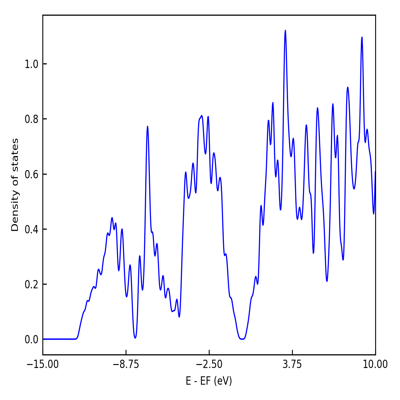

In [21]:
!dptb run -sk ./run/dos.json -i ./ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth -o ./property/dos
#!dptb run ./run/dos.json -i ./ckpt/md/2-3-300K_best_dptb_b5.000_c5.000_w0.100.pth -crt ./ckpt/md/2-3-300K_best_nnsk_b5.000_c5.000_w0.100.pth -o ./property/dos

from IPython.display import display
from PIL import Image

image = Image.open("./property/dos/results/dos.png")
image = image.resize((400, 400))
display(image)

#display(Image.open("./property/dos/results/dos.png"))

#### **4.2 Fermi Surface.**
DeePTB可以实现2D/3D费米面的绘制，样例参数位于 `run/ifermi.json`. 参数如下：
```json
{
    "structure":"./data/silicon.vasp",
    "task_options":{
        "task": "ifermi",    
        "fermisurface":{
            "mesh_grid":[8,8,8],
            "mu":-2,
            "intpfactor":3,
            "wigner_seitz":true,
            "nworkers":4,
            "plot_type":"plotly",
            "use_gui": false,
            "plot_fs_bands":false,
            "fs_plane":[0,0,1],
            "fs_distance":0.0,
            "plot_options":{}
        }
    }
}
```
其中各参数代表：
- `mesh_grid`: 绘制费米面的网格点
- `mu`: 费米能的平移，mu=0 表示没有平移. mu<0 表示向更低的能级shift，对应空穴掺杂, mu>0 表示向高能量平移，对应电子掺杂
- `intpfactor`: 插值系数. 系数越大，费米面越光滑
- `wigner_seitz`: 是否使用 wigner_seitz cell 绘制费米面
- `nworkers`: 并行计算费米面的worker数
- `plot_type`: 渲染工具类型，可选择 `plotly` 或 `matplotlib`.
- `use_gui`: 是否使用图形界面绘制， 对于没有GUI的命令行界面, 推荐设置为 `false`.
- `plot_fs_bands`: 是否绘制对于每条能带的费米面.
- `fs_plane`: 绘制 `fs_plane` 为 法向量 的费米面.
- `fs_distance`: 从原点到费米面的距离
- `plot_options`: 其他绘制参数

运行：

Warning! structure is not set in run option, read from input config file.
./data/silicon.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi by estimated value -9.27175521850586 .
DEEPTB INFO    48 unique rotations
DEEPTB INFO    73728 total k points in the sphere
DEEPTB INFO    Fermi surface is generated with totally 3 surfaces at -2 eV.
DEEPTB INFO    The band index of isosurface is 1
DEEPTB INFO    The band index of isosurface is 2
DEEPTB INFO    The band index of isosurface is 3
DEEPTB INFO    Ifermi calculation successfully completed.


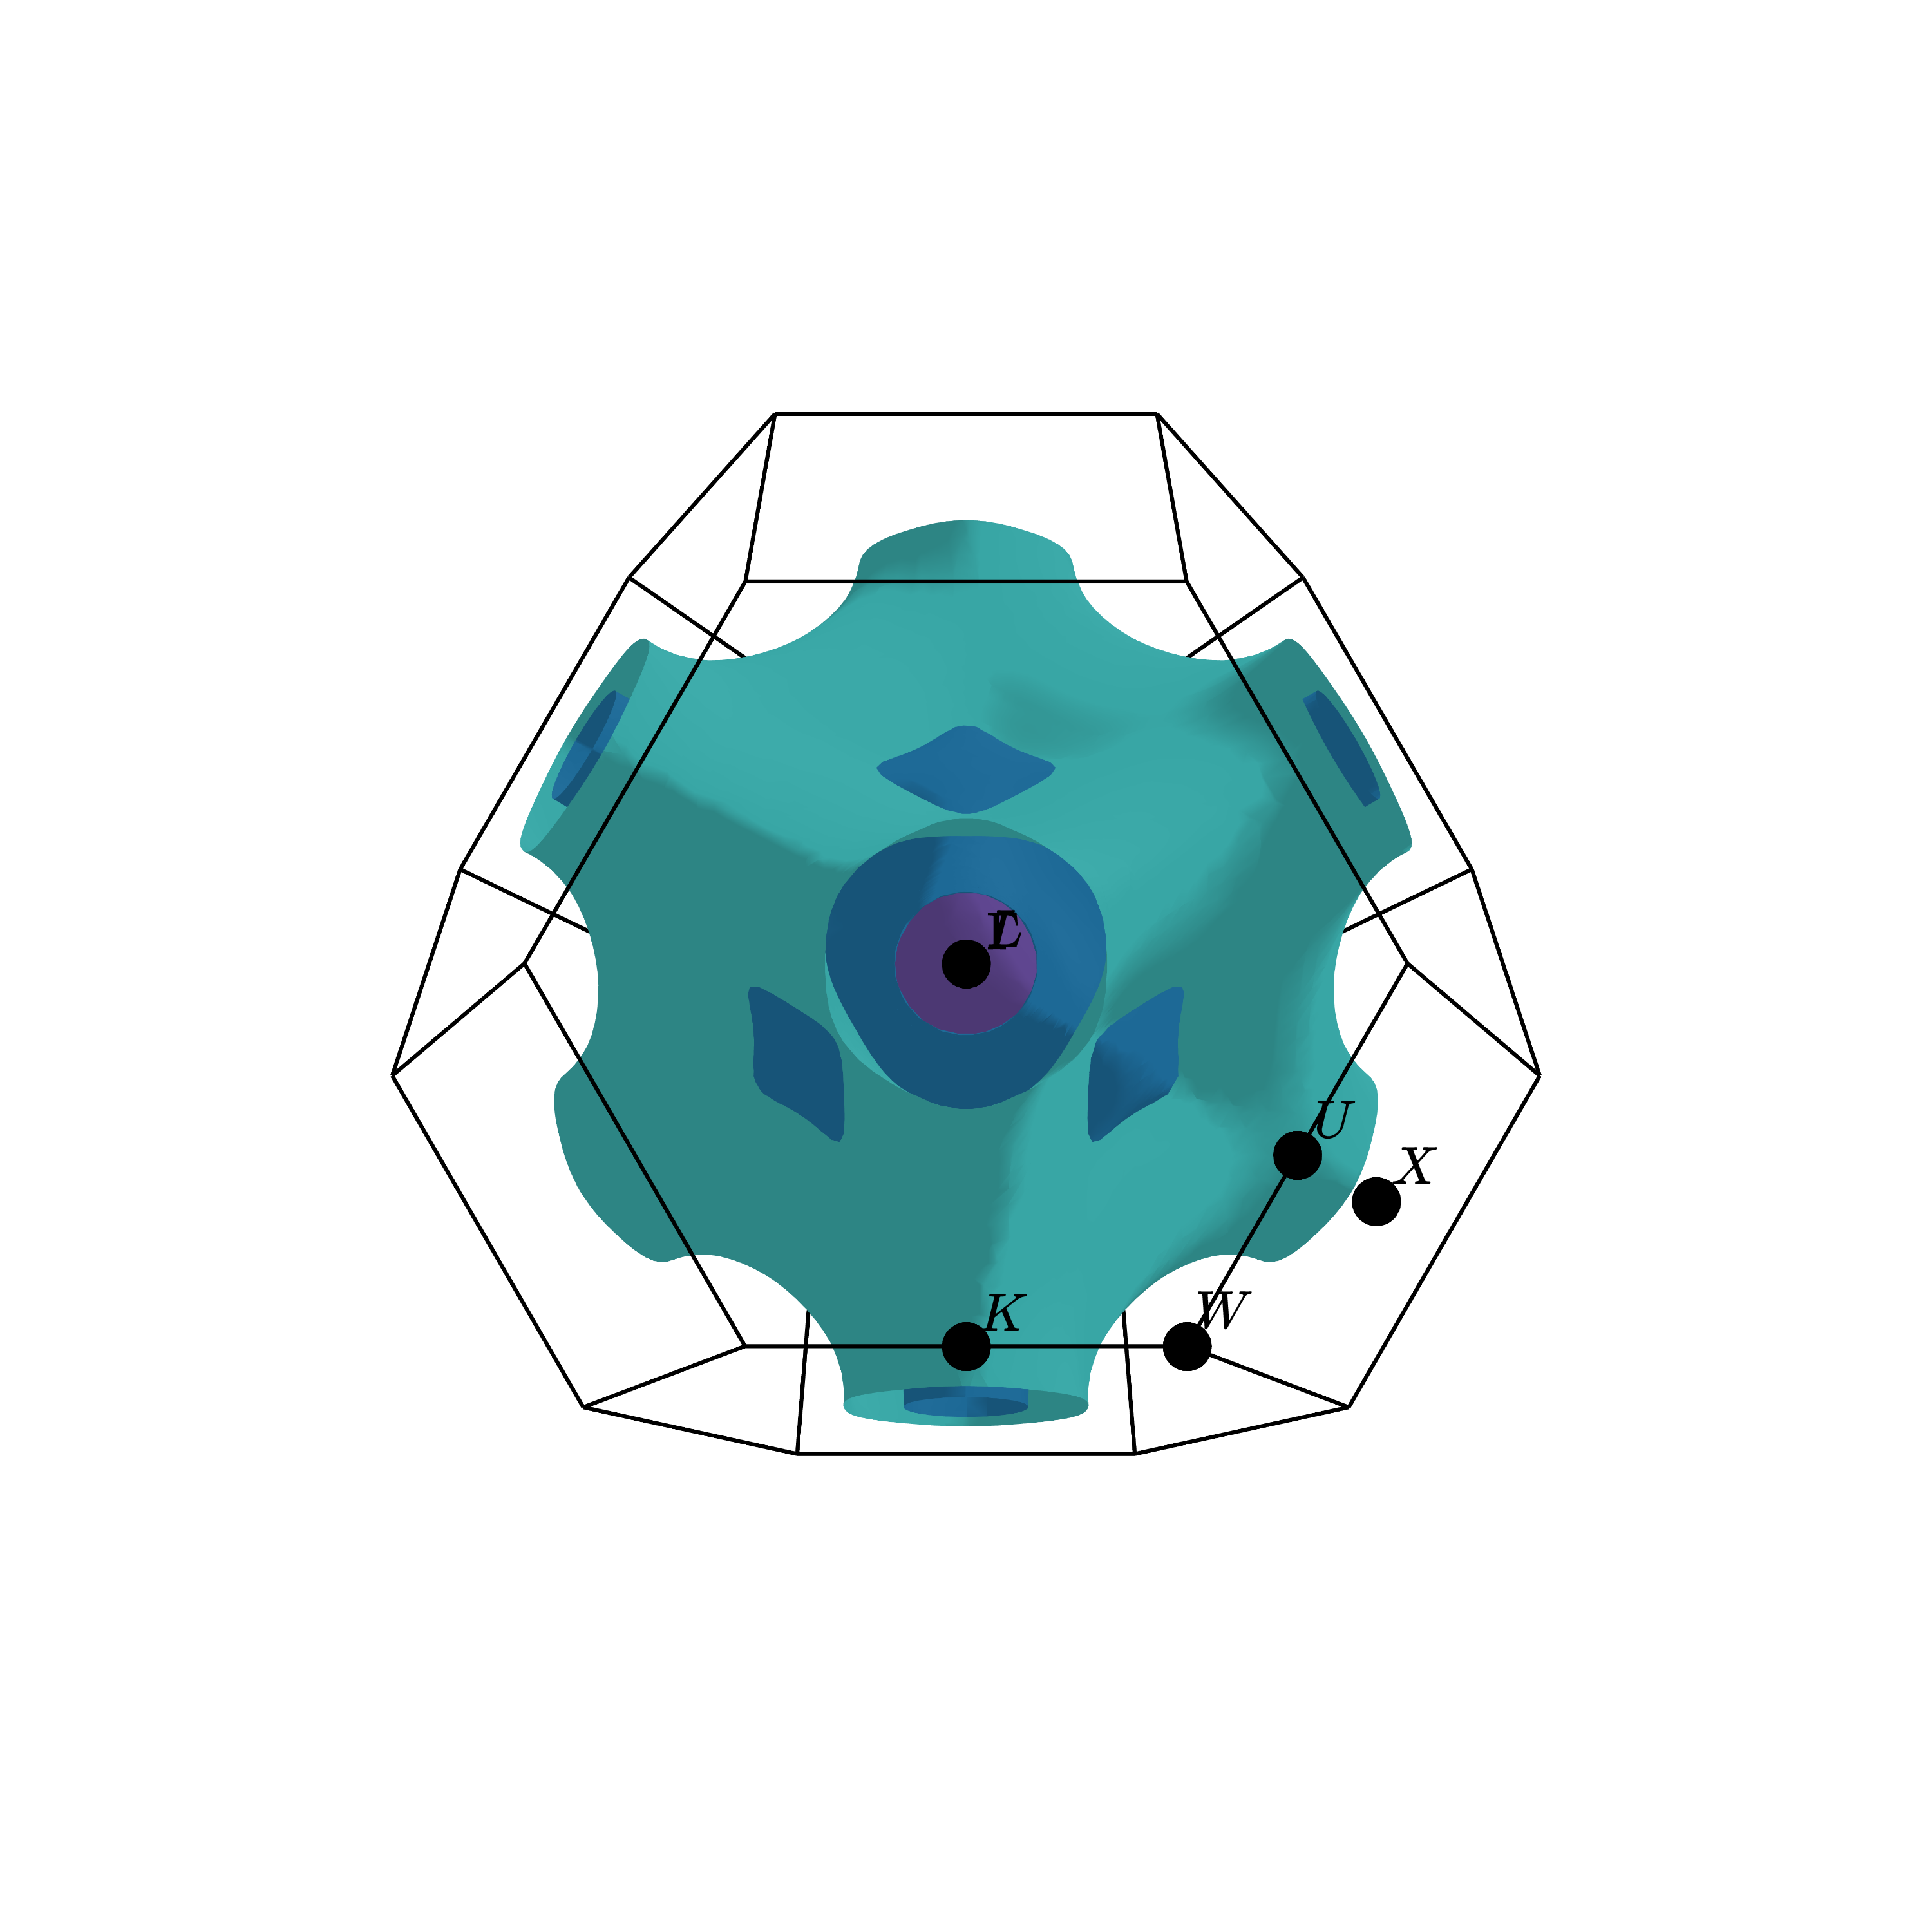

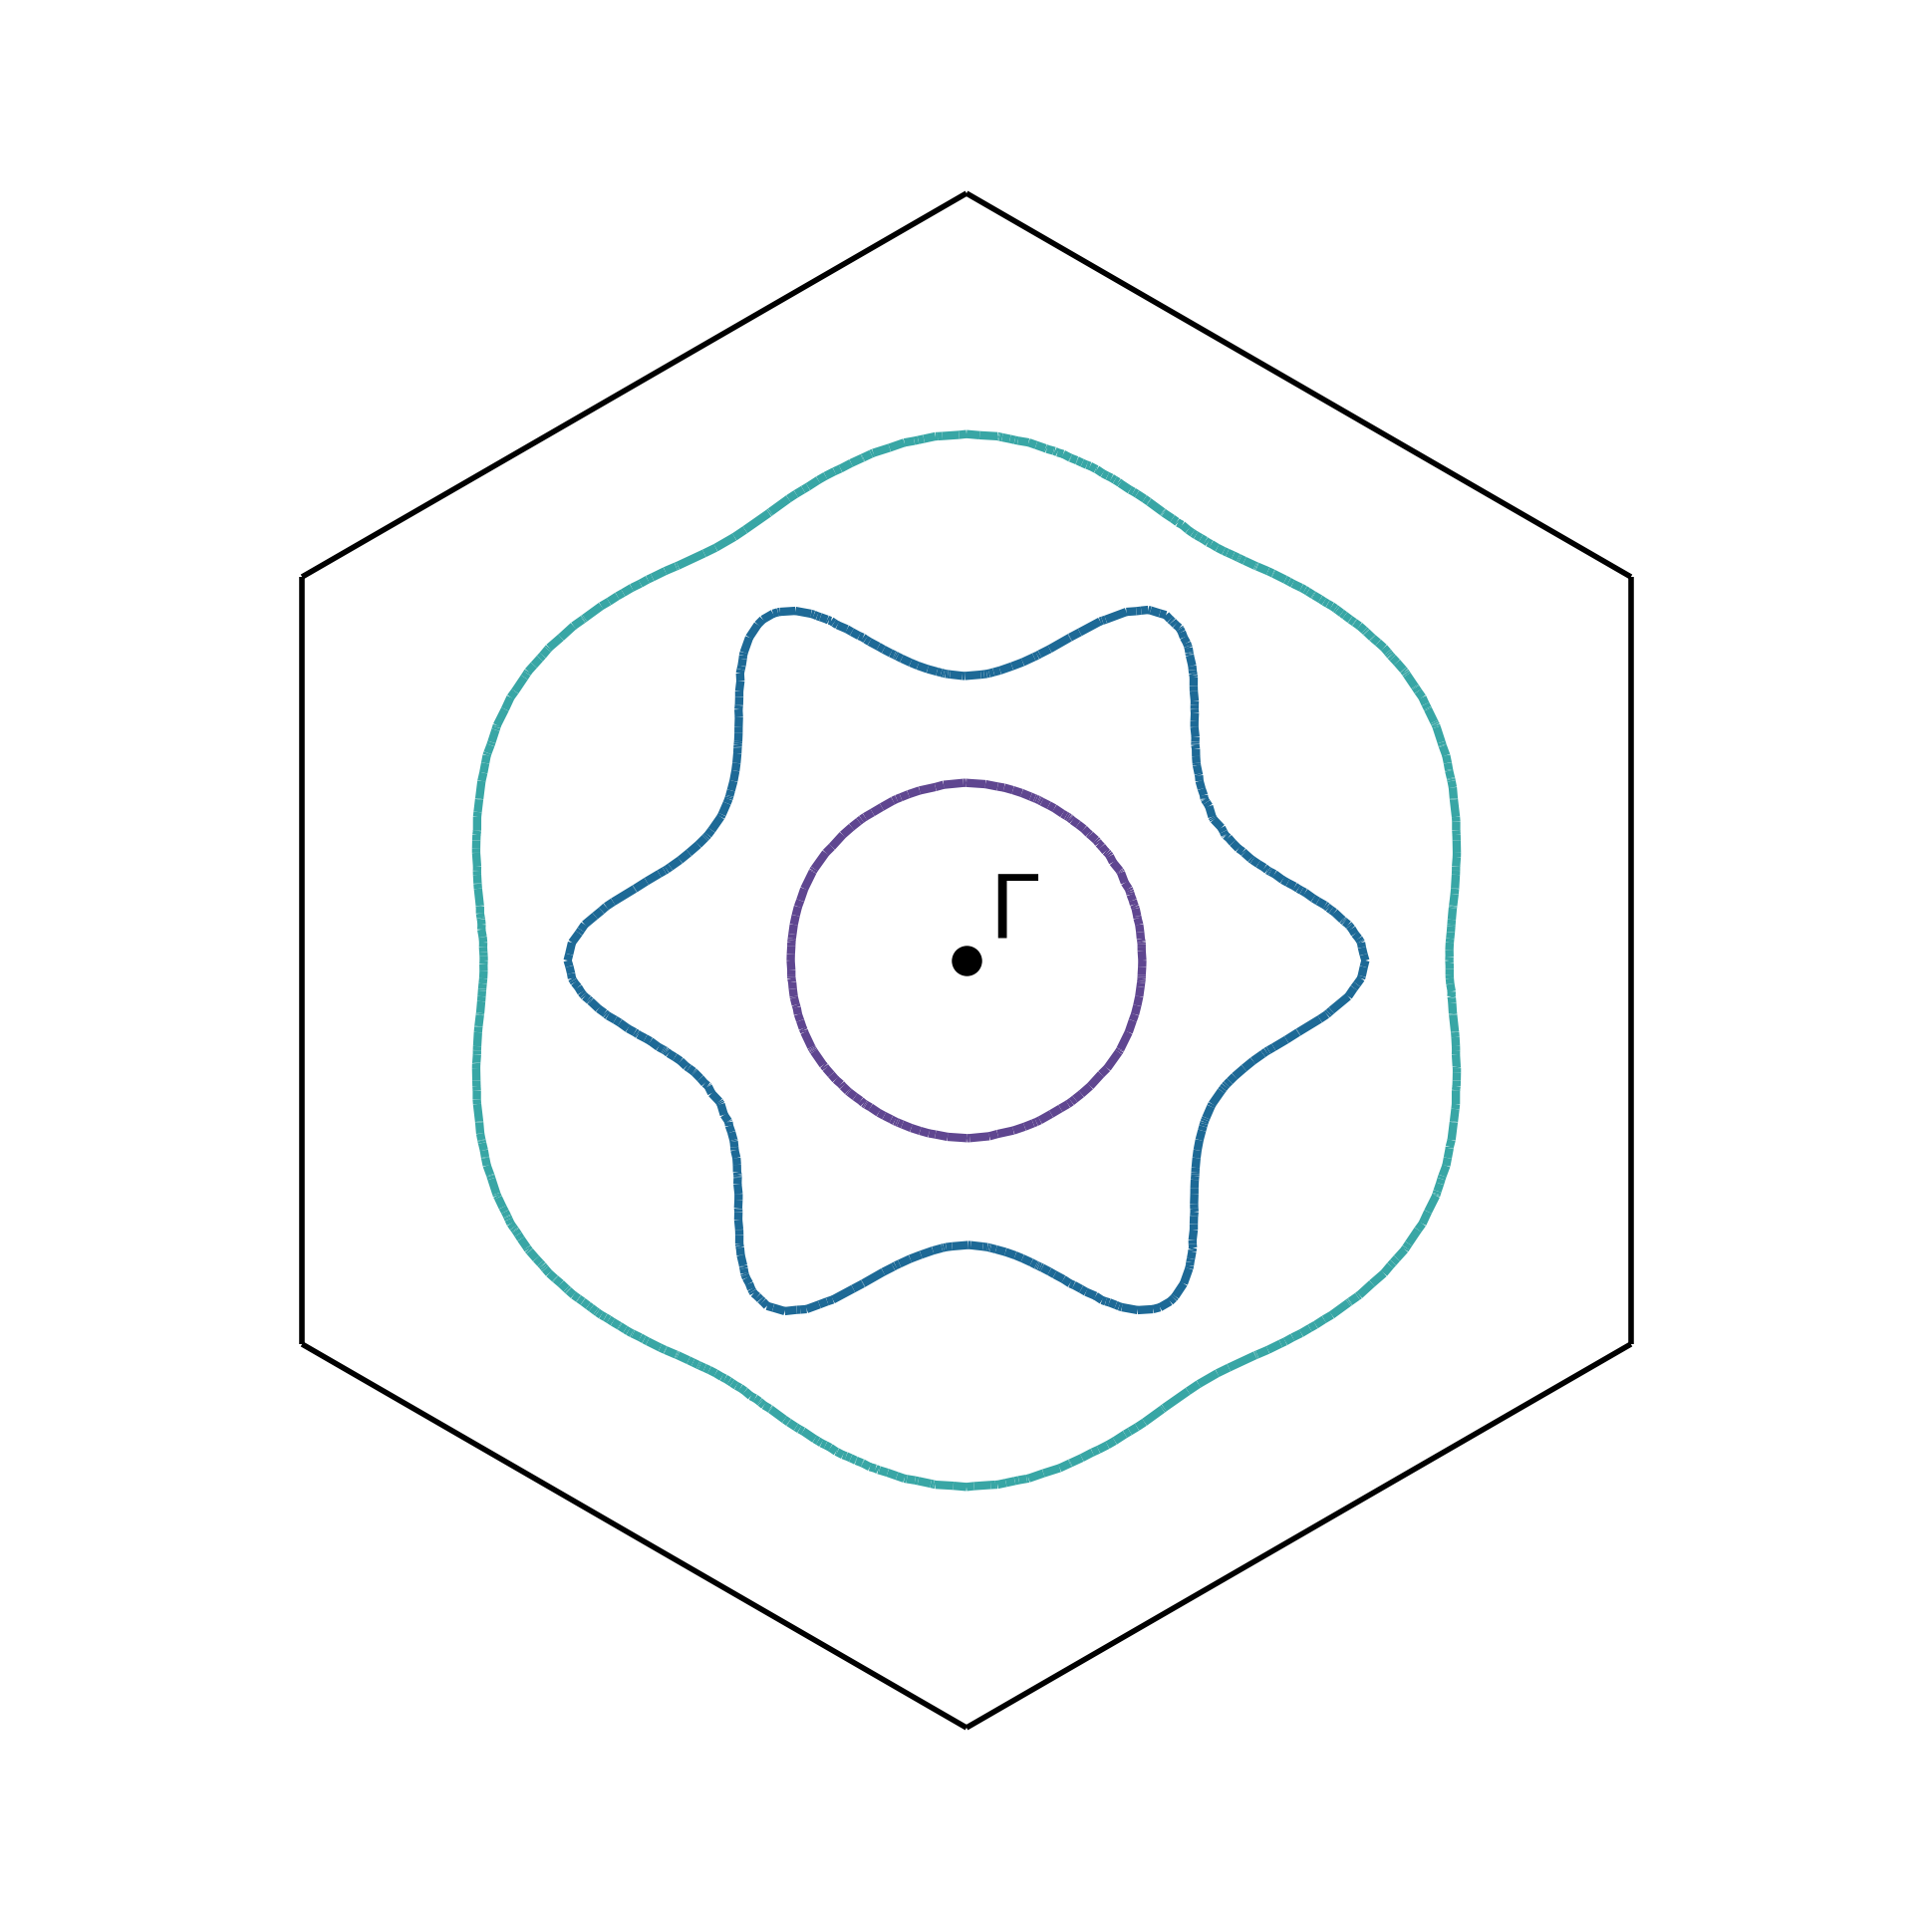

In [22]:
!dptb run -sk ./run/ifermi.json -i ./ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth -o ./property/ifermi
from IPython.display import display
from PIL import Image
image = Image.open("./property/ifermi/Ifermi_FS.png")
#image = image.resize((500, 500))
image1 = Image.open("./property/ifermi/Ifermi_FS_slice.png")
#image1 = image1.resize((400, 400))
display(image, image1)


#### **3.3 Fermi velocity.**
**DeePTB** 支持计算费米速度，参数为：
```json
{
    "structure":"./data/silicon.vasp",
    "task_options":{
        "task": "ifermi",    
        "fermisurface":{
            "mesh_grid":[8,8,8],
            "mu":-2,
            "intpfactor":3,
            "wigner_seitz":true,
            "nworkers":4,
            "plot_type":"plotly",
            "use_gui": false,
            "plot_fs_bands":false,
            "fs_plane":[0,0,1],
            "fs_distance":0.0,
            "plot_options":{}
        },
        "property":{
            "velocity":true,
            "color_properties":true,
            "colormap":"RdBu",
            "prop_plane":[0,0,1],
            "prop_distance":0.0,
            "plot_options":{
                "projection_axis": [0,0,1],
                "hide_surface": true,
                "hide_labels": true
            }
        }
    }
}
```

运行：

Warning! structure is not set in run option, read from input config file.
./data/silicon.vasp
# initial rotate H or S func.
DEEPTB INFO    set E_fermi by estimated value -9.27175521850586 .
DEEPTB INFO    48 unique rotations
DEEPTB INFO    73728 total k points in the sphere
DEEPTB INFO    Fermi surface is generated with totally 3 surfaces at -2 eV.
DEEPTB INFO    The band index of isosurface is 1
DEEPTB INFO    The band index of isosurface is 2
DEEPTB INFO    The band index of isosurface is 3
DEEPTB INFO    Ifermi calculation successfully completed.


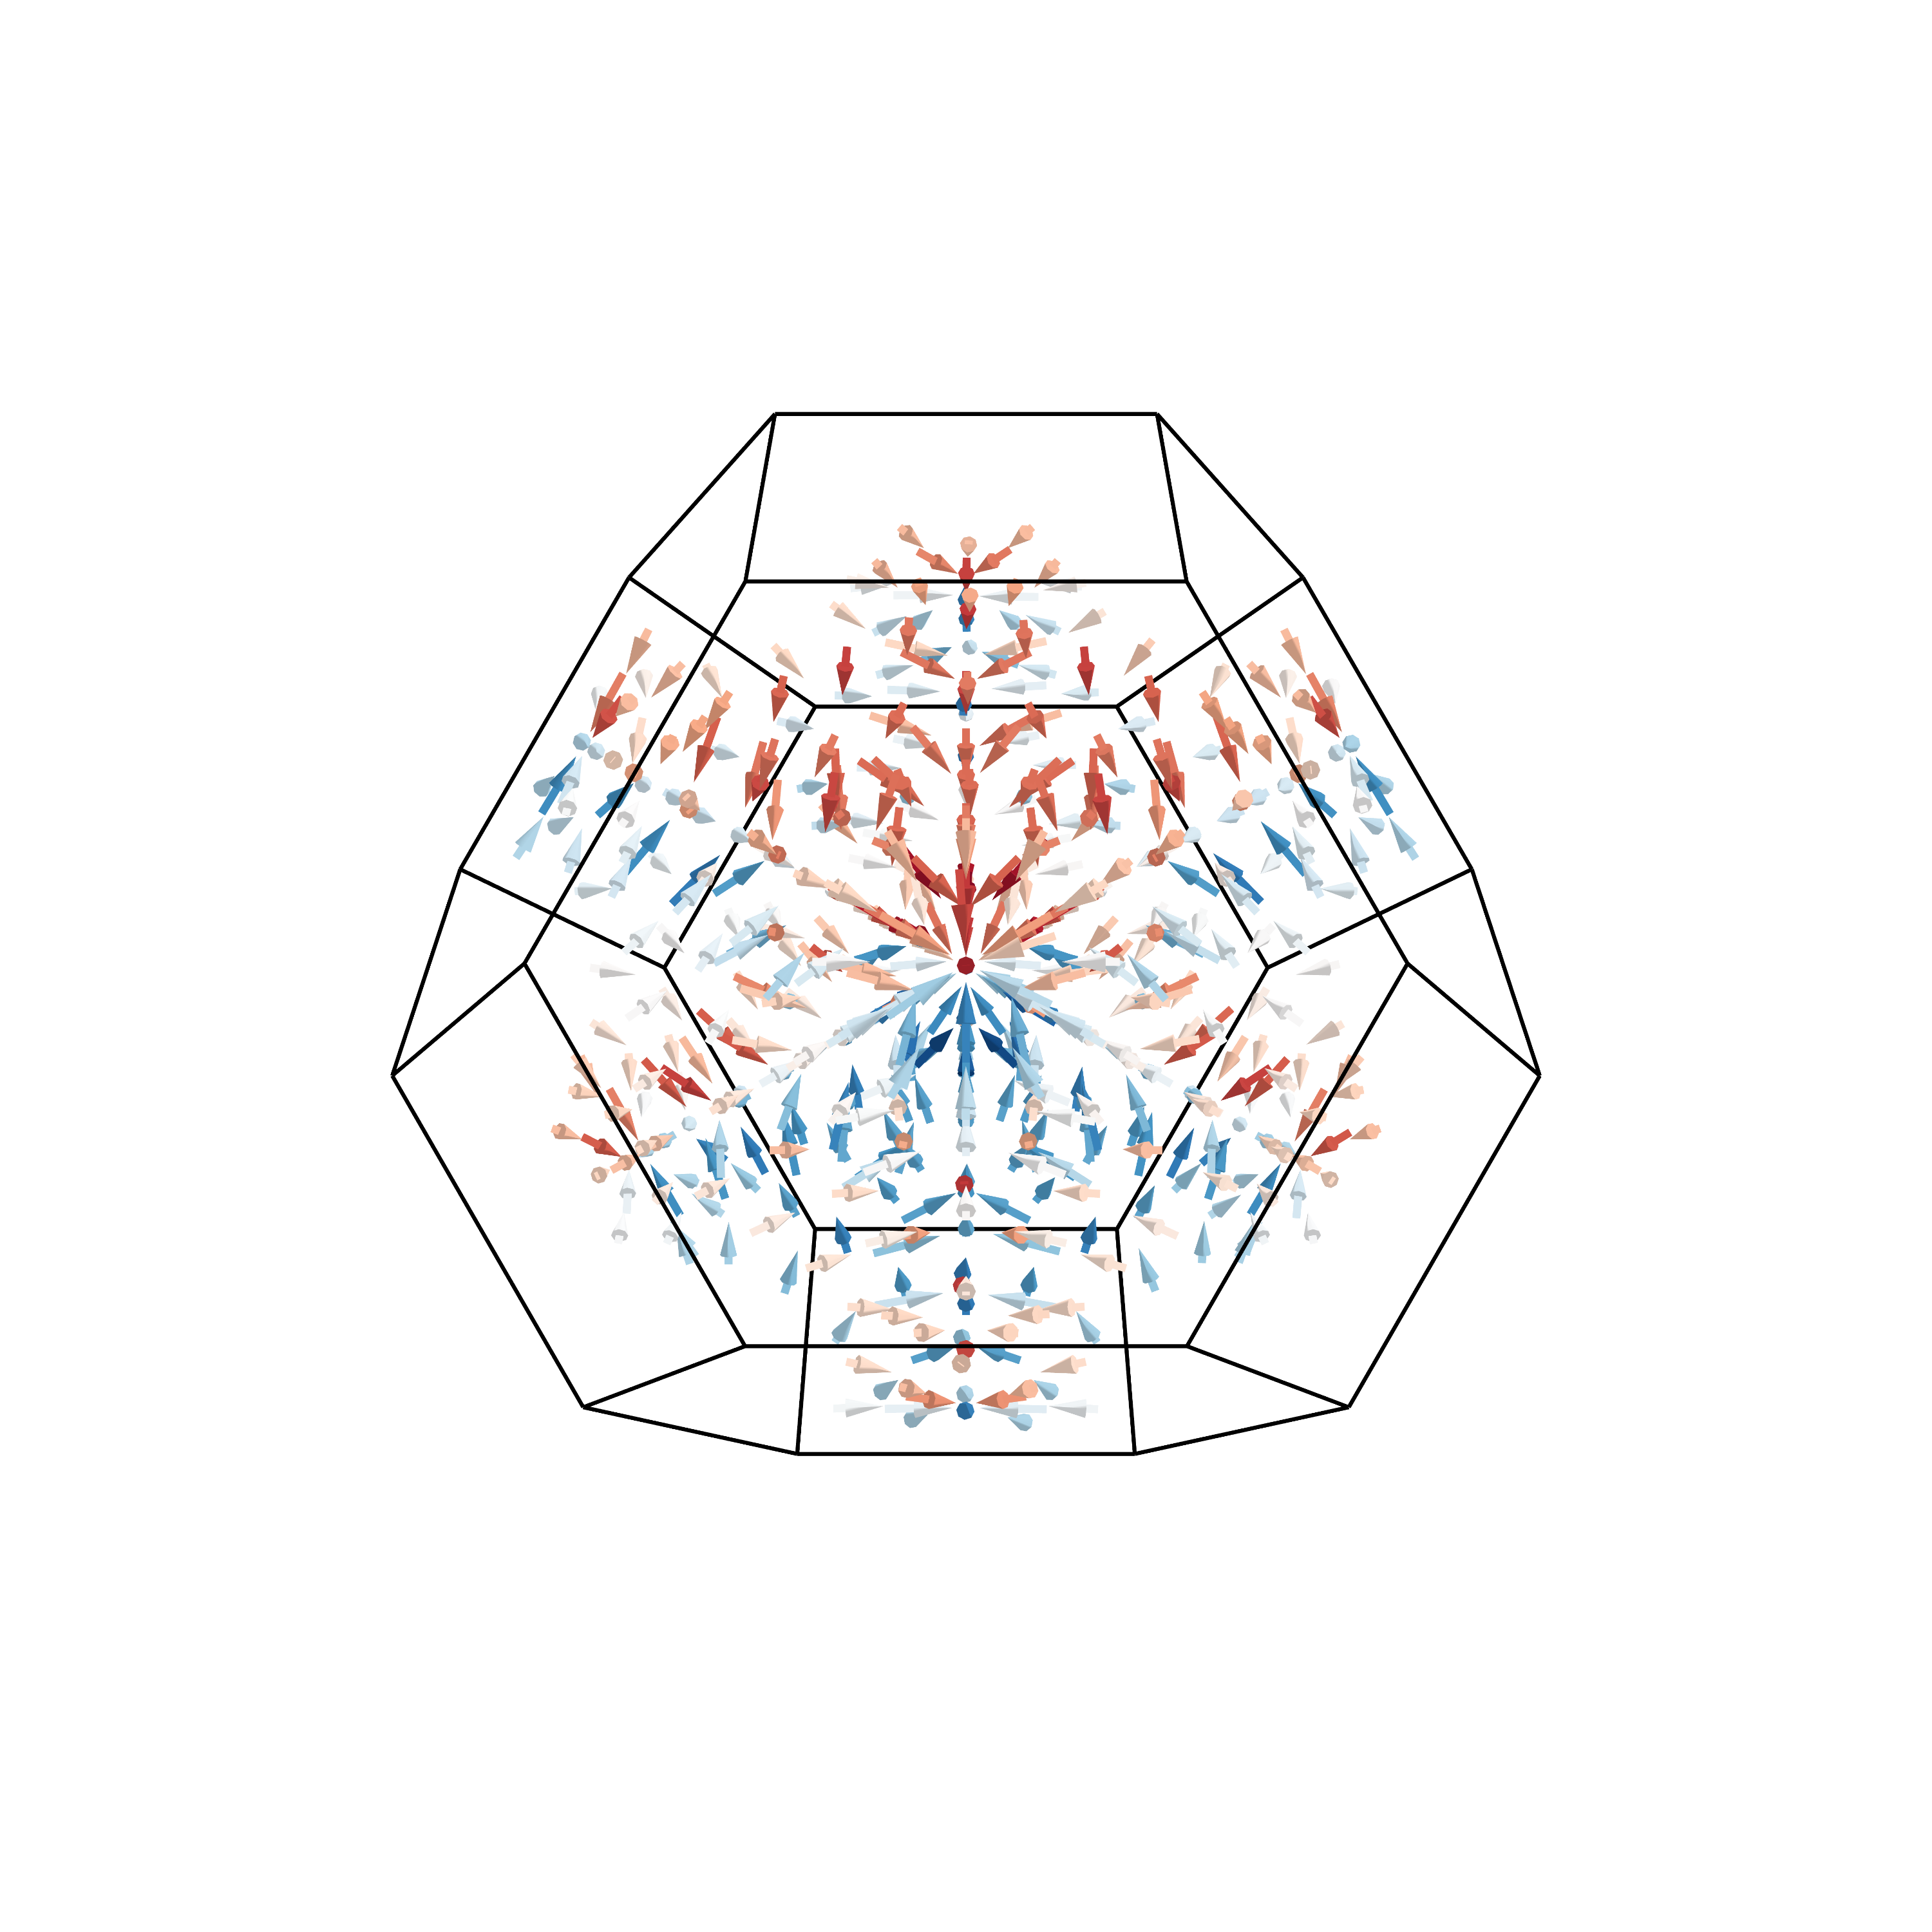

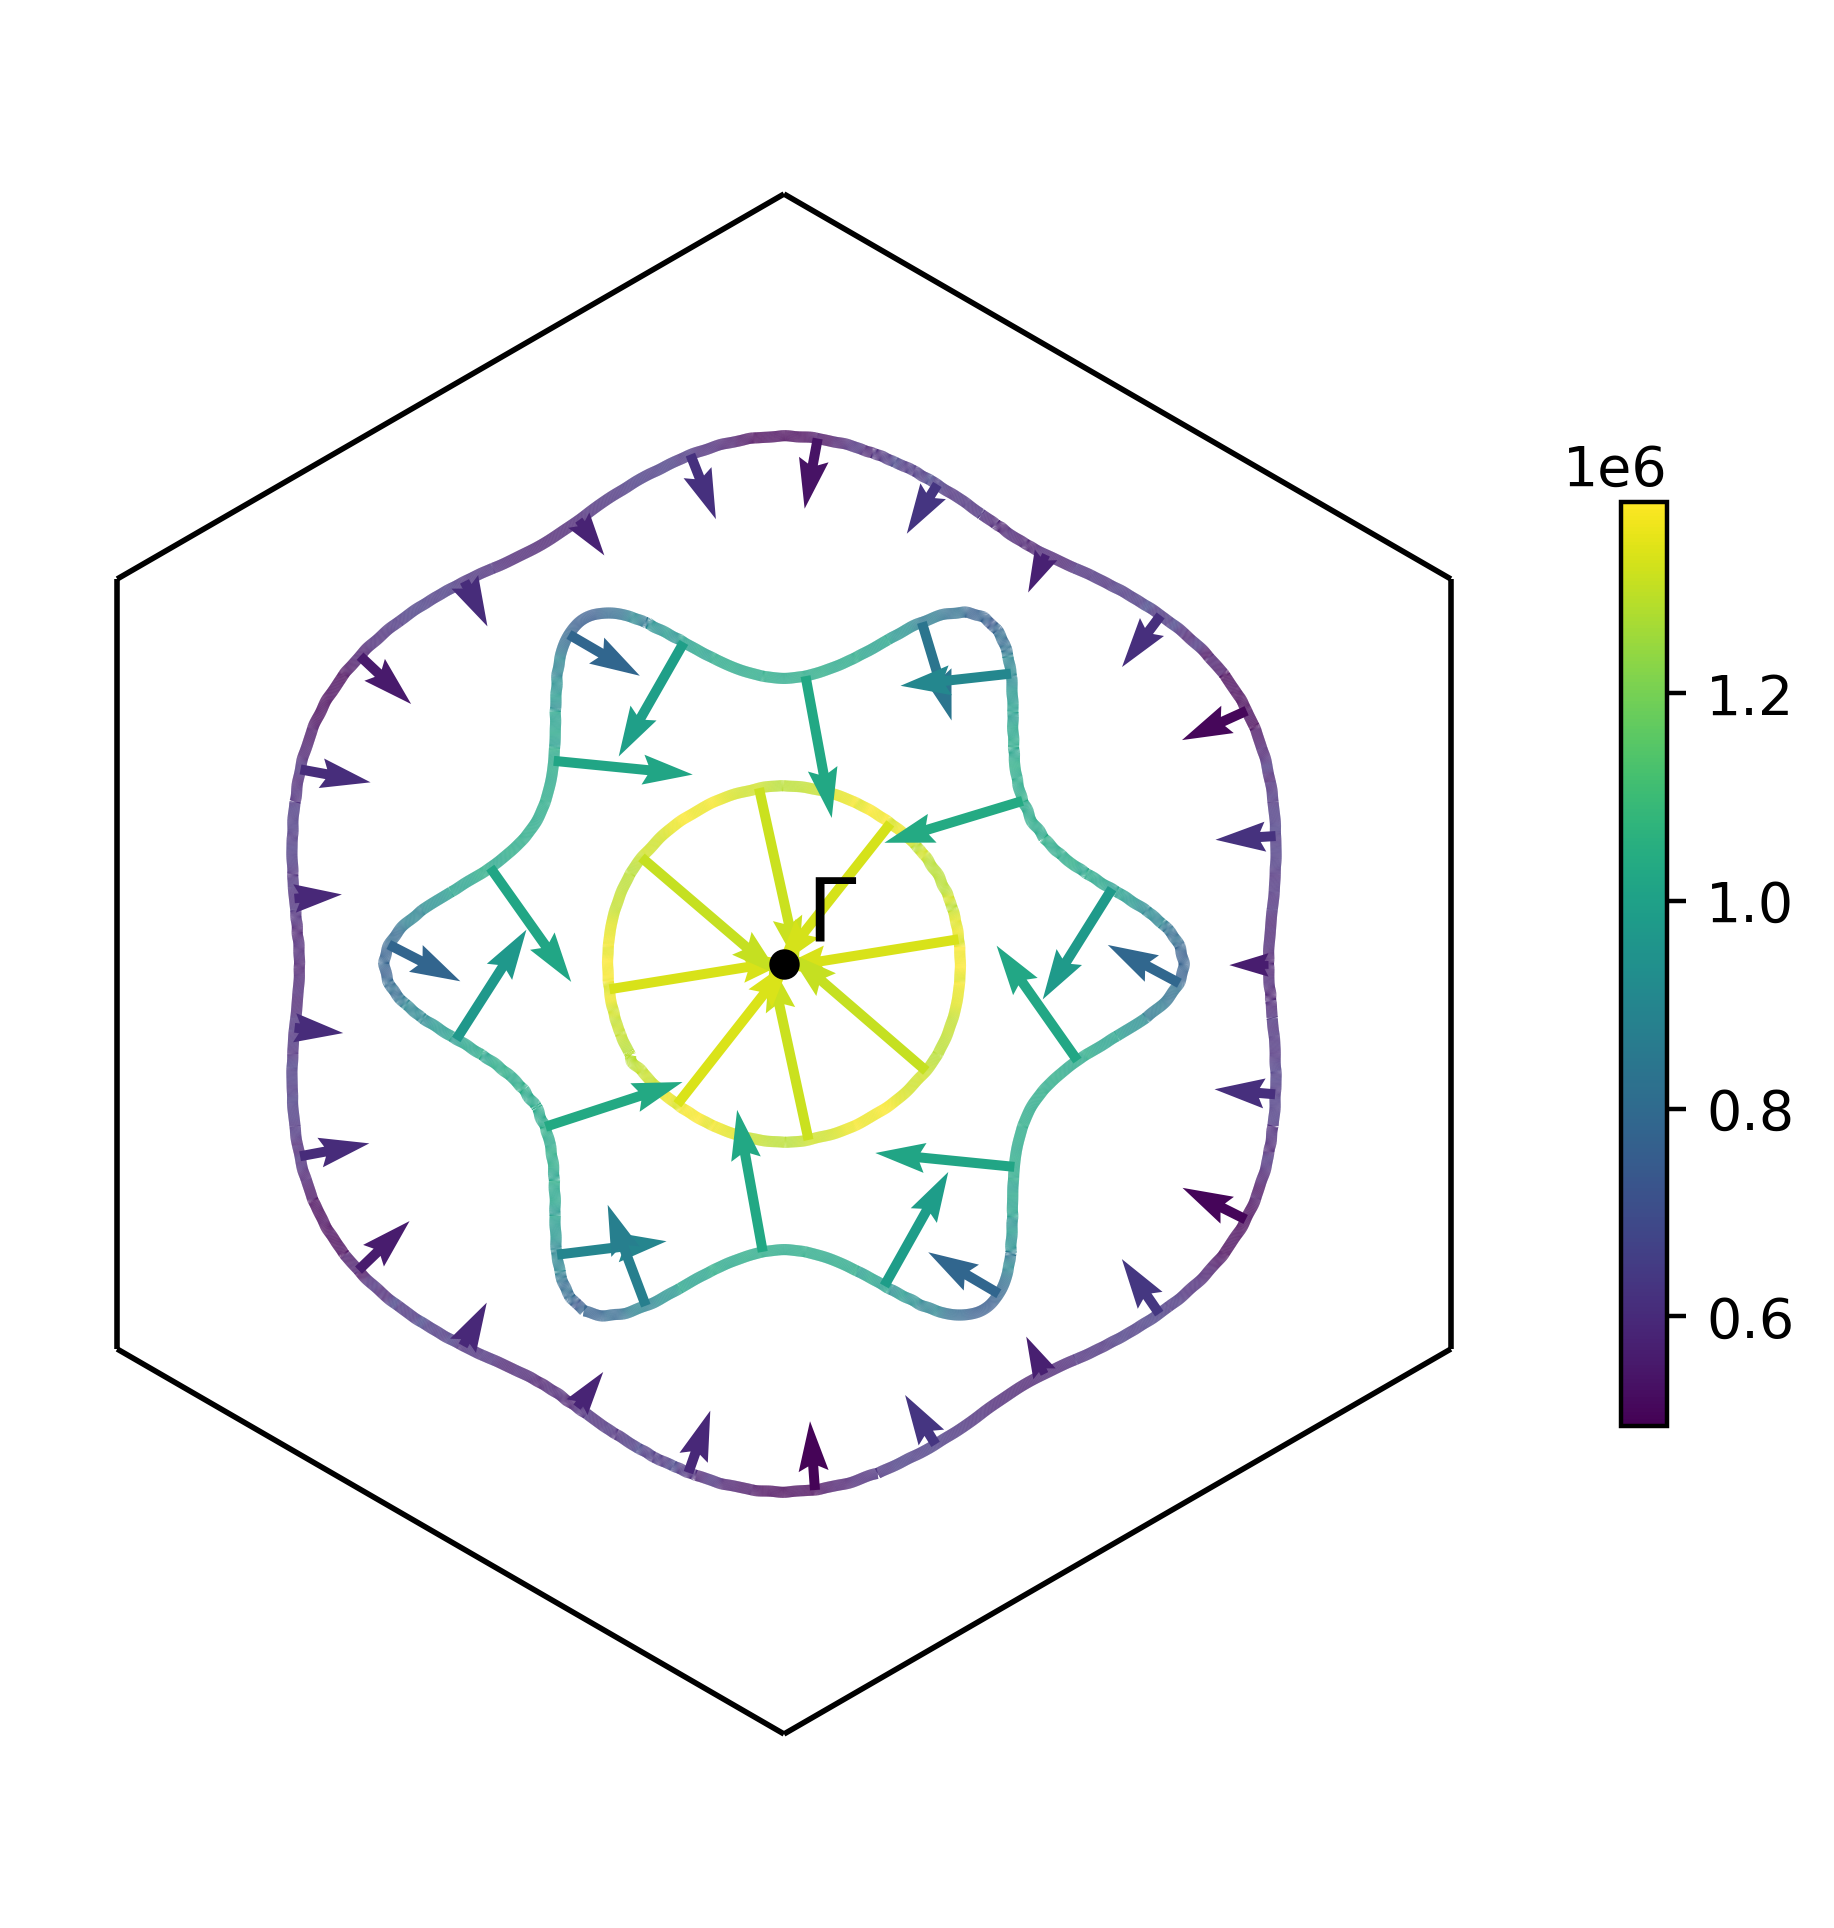

In [23]:
!dptb run -sk ./run/ifermi_velocity.json -i ./ckpt/2-2-2_best_nnsk_b5.000_c5.000_w0.100.pth -o ./property/ifermi_velocity
from PIL import Image

#display(Image.open("./property/ifermi_velocity/Ifermi_FS_velocity.png"))
#display(Image.open("./property/ifermi_velocity/Ifermi_FS_velcoity_slice.png"))

from IPython.display import display
from PIL import Image
image = Image.open("./property/ifermi_velocity/Ifermi_FS_velocity.png")
#image = image.resize((500, 500))
image1 = Image.open("./property/ifermi_velocity/Ifermi_FS_velcoity_slice.png")
#image1 = image1.resize((300, 300))

display(image, image1)
